# Apply and Visualize UMAP

**Gregory Way, 2019**

Here, I apply UMAP to the T2D V2F data and visualize the results according to various metadata features.

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(cowplot))
suppressPackageStartupMessages(library(umap))

In [2]:
set.seed(12345)

In [3]:
file <- file.path("data", "combined_normalized_variable_selected.tsv")

cp_cols <- readr::cols(
  .default = readr::col_double(),
  Metadata_Plate = readr::col_character(),
  Metadata_Well = readr::col_character(),
  Metadata_Assay_Plate_Barcode = readr::col_character(),
  Metadata_Plate_Map_Name = readr::col_character(),
  Metadata_well_position = readr::col_character(),
  Metadata_cell_line = readr::col_character(),
  Metadata_patient = readr::col_character(),
  Metadata_FFA = readr::col_character(),
  Metadata_diff_day = readr::col_character()
)

df <- readr::read_tsv(file, col_types = cp_cols)

dim(df)
head(df, 2)

[1] 530 549

Metadata_Plate,Metadata_Well,Metadata_Assay_Plate_Barcode,Metadata_Plate_Map_Name,Metadata_well_position,Metadata_cell_line,Metadata_patient,Metadata_FFA,Metadata_diff_day,Cells_AreaShape_EulerNumber,⋯,Nuclei_Texture_InfoMeas2_DNA_10_01,Nuclei_Texture_InfoMeas2_Mito_10_03,Nuclei_Texture_InverseDifferenceMoment_DNA_10_00,Nuclei_Texture_InverseDifferenceMoment_ER_10_02,Nuclei_Texture_InverseDifferenceMoment_Mito_10_02,Nuclei_Texture_InverseDifferenceMoment_Mito_20_02,Nuclei_Texture_SumAverage_DNA_20_03,Nuclei_Texture_SumVariance_AGP_20_01,Nuclei_Texture_SumVariance_ER_20_03,Nuclei_Texture_SumVariance_Mito_20_01
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BR00101080,B02,BR00101080,BR00101080,B02,vc,PAC_261,0,3,-3.8405647,⋯,-1.814082,0.0397319,1.401266,-0.3369062,-0.3880747,2.894933,0.6741113,0.9152793,0.5334064,0.9548021
BR00101080,B03,BR00101080,BR00101080,B03,sc,PAC_246,0,3,-0.1788428,⋯,-1.324510,-0.3304988,1.344428,2.7404322,0.7387430,0.208088,-0.3592615,-0.5264203,-0.7072999,-0.2738166


In [4]:
metadata_df <- df %>%
    dplyr::select(dplyr::starts_with("Metadata_"))

cp_df <- df %>%
    dplyr::select(-dplyr::starts_with("Metadata_"))

In [5]:
# Apply UMAP
cp_umap <- umap(as.matrix(cp_df))
cp_umap_df <- cp_umap$layout %>%
    dplyr::as_tibble()

colnames(cp_umap_df) <- c("umap_x", "umap_y")

# Merge with metadata
cp_umap_df <- cp_umap_df %>%
    dplyr::bind_cols(metadata_df)

head(cp_umap_df, 2)

Warning message:
“`as_tibble.matrix()` requires a matrix with column names or a `.name_repair` argument. Using compatibility `.name_repair`.
This warning is displayed once per session.”

umap_x,umap_y,Metadata_Plate,Metadata_Well,Metadata_Assay_Plate_Barcode,Metadata_Plate_Map_Name,Metadata_well_position,Metadata_cell_line,Metadata_patient,Metadata_FFA,Metadata_diff_day
<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
-4.699175,1.975254,BR00101080,B02,BR00101080,BR00101080,B02,vc,PAC_261,0,3
-3.922004,-1.675195,BR00101080,B03,BR00101080,BR00101080,B03,sc,PAC_246,0,3


In [6]:
# Write umap output
file <- file.path("results", "umap_with_metadata.tsv")
readr::write_tsv(cp_umap_df, file)

## Plot and Save UMAP Figures

In [7]:
# Reorder some factors
cp_umap_df$Metadata_diff_day <-
    factor(cp_umap_df$Metadata_diff_day, levels = c("0", "1", "2", "3", "7", "10", "14", "15", "15+iso"))
cp_umap_df$Metadata_patient <-
    factor(cp_umap_df$Metadata_patient,
           levels = c("PAC_164", "PAC_246", "PAC_261", "PAC_266", "hBAT", "hWAT", "SGBS"))

In [8]:
# Set Constants
legend_text_size = 7
legend_title_size = 8
legend_key_height = 0.18
axis_title_size = 8
axis_text_size = 7
geom_point_size = 0.8

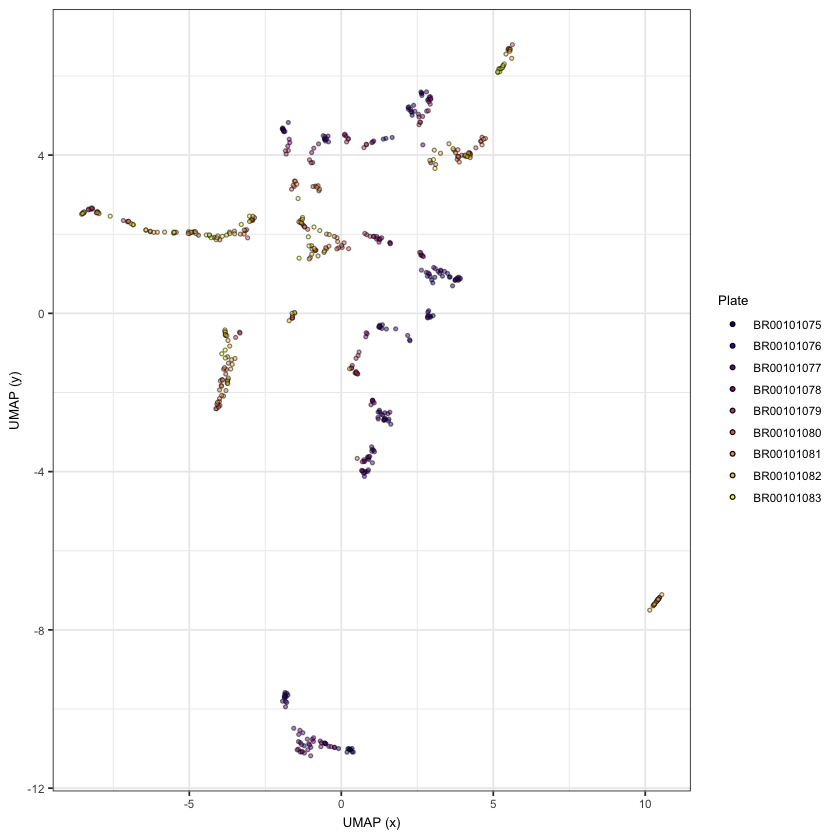

In [9]:
plate_gg <-
    ggplot(cp_umap_df, aes(umap_x, umap_y)) +
        geom_point(aes(fill = Metadata_Plate),
                   size = geom_point_size,
                   alpha = 0.5,
                   color = "black",
                   pch = 21) +
        theme_bw() +
        xlab("UMAP (x)") +
        ylab("UMAP (y)") +
        scale_fill_viridis_d(name = "Plate", option = "plasma") +
        guides(fill = guide_legend(keyheight = legend_key_height,
                                   default.unit = "inch",
                                   override.aes = list(alpha = 1,
                                                       size = 1))) +
        theme(legend.text = element_text(size = legend_text_size),
              legend.title = element_text(size = legend_title_size),
              axis.title = element_text(size = axis_title_size),
              axis.text = element_text(size = axis_text_size))

plate_gg

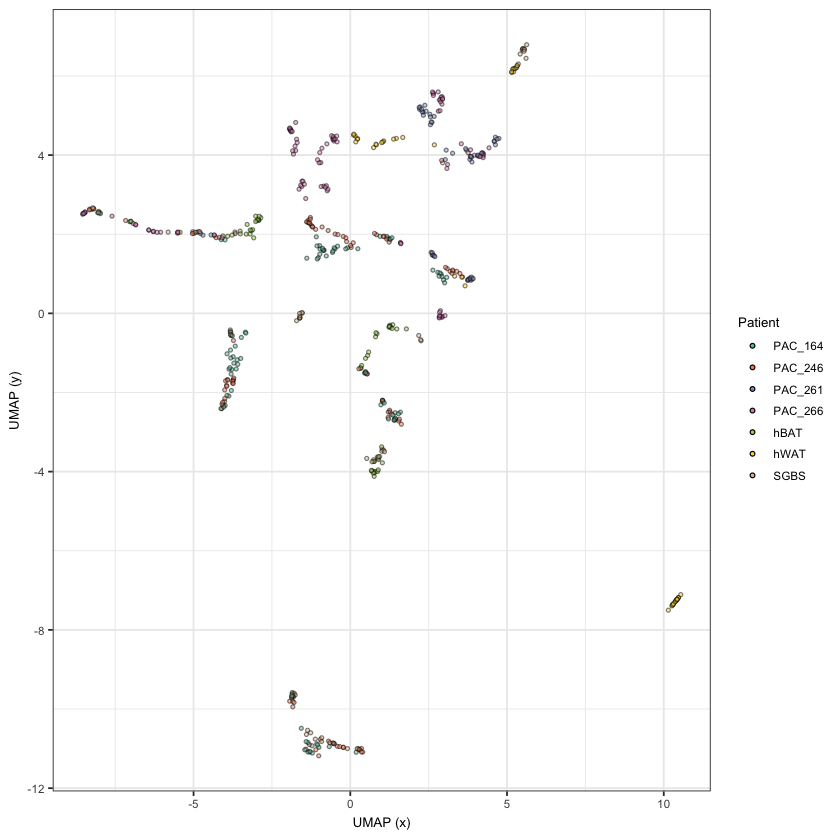

In [10]:
patient_gg <-
    ggplot(cp_umap_df, aes(umap_x, umap_y)) +
        geom_point(aes(fill = Metadata_patient),
                   size = geom_point_size,
                   alpha = 0.5,
                   pch = 21,
                   color = "black") +
        theme_bw() +
        xlab("UMAP (x)") +
        ylab("UMAP (y)") +
        scale_fill_manual(name = "Patient",
                           values = c("#66c2a5",
                                      "#fc8d62",
                                      "#8da0cb",
                                      "#e78ac3",
                                      "#a6d854",
                                      "#ffd92f",
                                      "#e5c494")) +
        guides(fill = guide_legend(keyheight = legend_key_height,
                                   default.unit = "inch",
                                   override.aes = list(alpha = 1,
                                                       size = 1))) +
        theme(legend.text = element_text(size = legend_text_size),
              legend.title = element_text(size = legend_title_size),
              axis.title = element_text(size = axis_title_size),
              axis.text = element_text(size = axis_text_size))

patient_gg

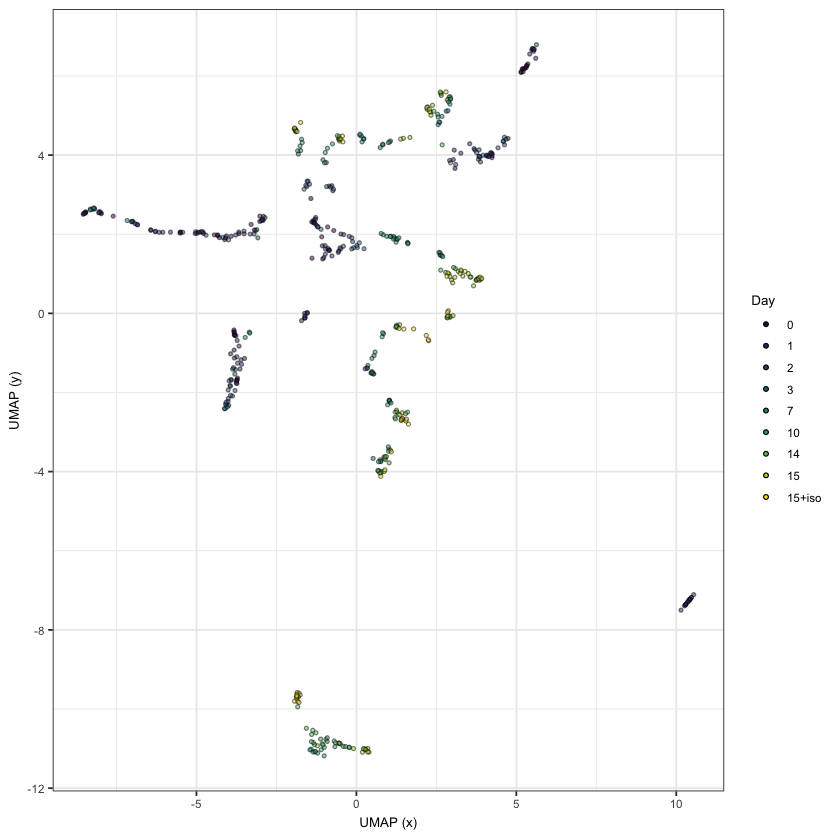

In [11]:
day_gg <- 
    ggplot(cp_umap_df, aes(umap_x, umap_y)) +
        geom_point(aes(fill = Metadata_diff_day),
                   size = geom_point_size,
                   alpha = 0.5,
                   pch = 21,
                   color = "black") +
        xlab("UMAP (x)") +
        ylab("UMAP (y)") +
        theme_bw() +
        scale_fill_viridis_d(name = "Day") +
        guides(fill = guide_legend(keyheight = legend_key_height,
                                   default.unit = "inch",
                                   override.aes = list(alpha = 1,
                                                       size = 1))) +
        theme(legend.text = element_text(size = legend_text_size),
              legend.title = element_text(size = legend_title_size),
              axis.title = element_text(size = axis_title_size),
              axis.text = element_text(size = axis_text_size))

day_gg

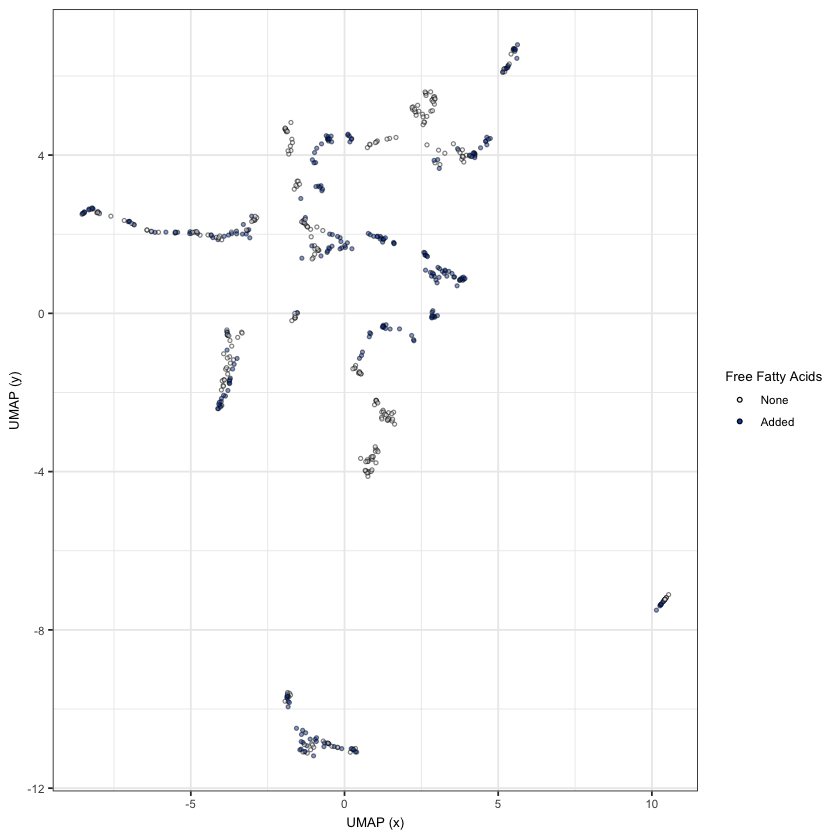

In [12]:
ffa_gg <-
    ggplot(cp_umap_df, aes(umap_x, umap_y)) +
        geom_point(aes(fill = Metadata_FFA),
                   size = geom_point_size,
                   alpha = 0.5,
                   pch = 21,
                   color = 'black') +
        xlab("UMAP (x)") +
        ylab("UMAP (y)") +
        theme_bw() +
        scale_fill_manual(name = "Free Fatty Acids",
                          values = c("0" = "#f2f4f7", "1" = "#0a4cb5"),
                          labels = c("0" = "None", "1" = "Added")) +
        guides(fill = guide_legend(keyheight = legend_key_height,
                                   default.unit = "inch",
                                   override.aes = list(alpha = 1,
                                                       size = 1))) +
        theme(legend.text = element_text(size = legend_text_size),
              legend.title = element_text(size = legend_title_size),
              axis.title = element_text(size = axis_title_size),
              axis.text = element_text(size = axis_text_size))

ffa_gg

## Combine Plots into Single Cowplot

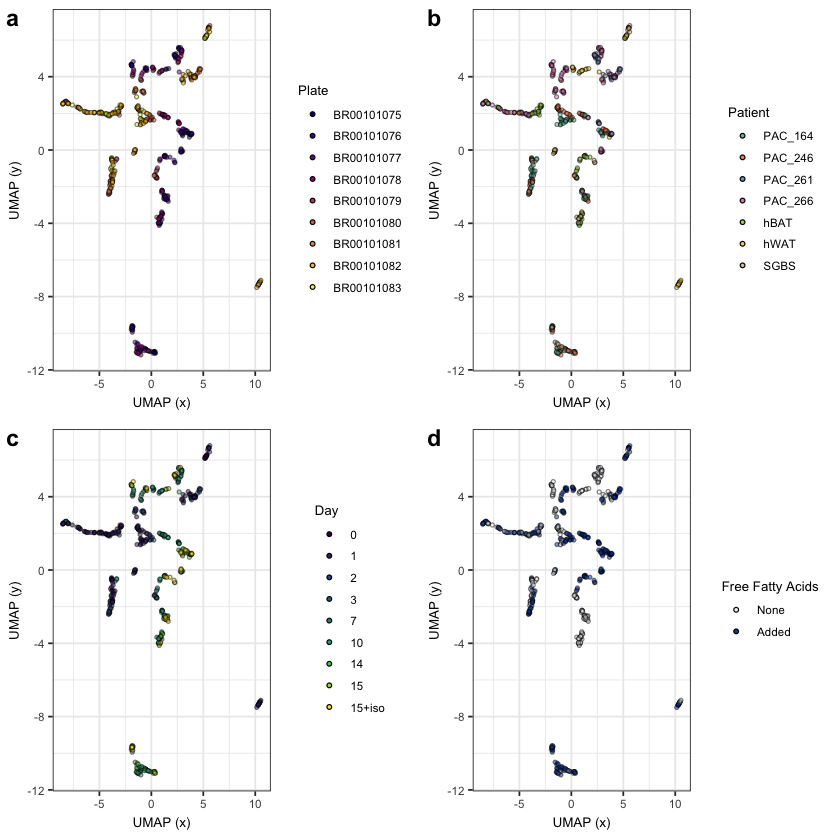

In [13]:
main_plot <- (
    cowplot::plot_grid(
        plate_gg,
        patient_gg,
        day_gg,
        ffa_gg,
        labels = c("a", "b", "c", "d"),
        ncol = 2,
        nrow = 2,
        align = "v"
    )
)

main_plot

In [14]:
for(extension in c('.png', '.pdf')) {
    sup_file <- paste0("umap_metadata", extension)
    sup_file <- file.path("figures", sup_file)
    cowplot::save_plot(filename = sup_file,
                       plot = main_plot,
                       base_height = 130,
                       base_width = 200,
                       unit = "mm")
}